<a href="https://colab.research.google.com/github/logikon-ai/logikon/blob/main/examples/monitor_cot_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guide for Monitoring Chain-of-Thought Apps (#1)

**Logikon `/\/`** – *Analyzing and Evaluating LLM Reasoning Traces*

This notebook showcases the reasoning **metrics** and artifacts that can be generated with the `logikon` python library.

We're using 🤗's lightweight `zephyr-7b-beta` as **expert model** in this demo for its speed and small footprint. It tends to produce argumentative analyses that are creative and eloquent, rather than rigorous and exact -- and may hence not be the optimal expert model for your use cases.

> ⚠️ **Important notice.**
>
> **Logikon `/\/`** is in early development stage:
> * the package is subject to change at any time;
> * results can vary due to changes in methods, pipelines, or underlying models;
> * current speed and quality of evaluation results are not representative of future product.


**Table of contents**

1. [Set-up](#set-up)
2. [Collect metrics and artifacts](#collect)
3. [Run analysis](#run)
4. [Inspect results](#inspect)

## An advanced LLM workflow with deliberative prompting

In [25]:
%%capture
%pip install huggingface_hub

In [27]:
# products for which ad text will be written
products = [
    {
        "product": "QuantumGlow Lighting",
        "productinfo": (
            "QuantumGlow Lighting Products: High-tech, energy-efficient lighting solutions using "
            "quantum technology for improved brightness and longevity.\n"
            "1. Quantum Efficiency:\n"
            "* Harnesses quantum technology for unparalleled light emission efficiency.\n"
            "* Maximizes the conversion of electrical energy into visible light, minimizing energy waste.\n"
            "2. Extended Lifespan:\n"
            "* Prolonged operational life compared to traditional lighting sources.\n"
            "* Reduced frequency of replacements, minimizing maintenance costs.\n"
            "3. Dynamic Brightness Control:\n"
            "* Adjustable brightness levels for customizable lighting experiences.\n"
            "* Smooth dimming capabilities without compromising efficiency.\n"
            "4. Environmental Sustainability:\n"
            "* Low environmental impact with energy-efficient design.\n"
            "* Supports eco-friendly initiatives by reducing overall energy consumption.\n"
            "5. Instant Illumination:\n"
            "* Instantaneous light output without warm-up time.\n"
            "* Ideal for applications requiring immediate brightness upon activation.\n"
            "6. Smart Integration:\n"
            "* Compatible with smart home systems for seamless automation.\n"
            "* Enables remote control and scheduling for enhanced convenience.\n"
        ),
    },
]

In [29]:
# criteria used to assess alternative ad text drafts
criteria = [
    (
      "Include Your Product Name/Service. "
      "Don’t keep your product or service a secret. Include it inside your headline, "
      "an in your description. Make it super clear what you are offering."
    ),
    (
      "Include Your Call To Action. "
      "Your Call To Action (CTA) is what you want users to do when they get to your website. "
      "Things like schedule a consult, learn more today, contact us today, browse now, shop now, "
      "etc. are all examples of a CTA."
    ),
    (
      "Use All Your Characters. "
      "You get a limited amount of characters: 30 characters per headline and 90 characters per description. "
      "Maximize every character and use abbreviations when possible to help save you some space."
    ),
    (
      "Be Clear. "
      "Make sure your messaging stays clear and to the point. "
      "If you find yourself trying to cover too many things in one ad, "
      "it might be a sign that you need to make another ad group."
    )

]

In [26]:
# prompt template #1
# to elicit ad text
# standard generative prompt
draft_prompt = (
  "<s>[INST] "
  "*Assignment: Write a Google Ad Text for {product}*\n\n"
  "Billion Google Searches Are Made Each Day People are searching for things all the time, "
  "all day long. Some of them are searching for our product. Advertising on Google is a "
  "great way to create brand awareness and generate new business. However, with lots of "
  "competition, you need to make sure your ads will stand out and get you the clicks you "
  "deserve.\n\n"
  "Can you please help us in writing a first-class ad text for our product {product}?\n\n"
  "Please take into account the following product info:\n\n"
  "~~~\n"
  "{productinfo}"
  "~~~\n"
  "Write a Google ad for {product}. "
  "More specifically, provide a title (max 30 characters) and a description (max 90 characters). "
  "Provide title and description in a separate line each."
  "[/INST]\n"
)

In [143]:
# prompt template #2
# to elicit evaluation of alternative drafts
# deliberative prompt
eval_prompt = (
  "<s>[INST] "
  "*Assignment: Assess pros and cons of two alternative ad texts*\n\n"
  "We are going to advertize our product {product} with Google. "
  "My colleagues Jennifer and Catherine have written two alternative ad texts. I have to pick the best one. "
  "Please help me in doing so by comparing and assessing the two alternative ad texts for {product}.\n"
  "Here is some background info about the product to-be advertized:\n"
  "<productinfo>\n"
  "{productinfo}"
  "</productinfo>\n"
  "Assess and compare the two alternatives drafted by Jennifer and Catherine (below) with regard to the following criteria.\n"
  "<criteria>\n"
  "{criteria}"
  "</criteria>\n"
  "The alternative Google ad texts you're supposed to assess are "
  "(title and description are provided in separate lines):\n"
  "<alternatives>\n"
  "# Jennifer's ad\n"
  "{ad_a}\n"
  "# Catherine's ad\n"
  "{ad_b}\n"
  "</alternatives>\n"
  "Compare the alternatives by gathering the diverse pros and cons that speak for / against using "
  "Jennifer's or Catherine's text."
  "[/INST]\n"
)

In [144]:
# prompt template #3
# to elicit choice of best draft
# decision prompt
decision_prompt = (
  "<s>[INST] "
  "*Assignment: Pick best ad text given pros and cons*\n\n"
  "Jennifer and Catherine have written alternative ad texts. "
  "Here are the pros and cons to be considered when choosing which text to use:\n"
  "<reasoning>\n"
  "{reasoning}"
  "</reasoning>\n"
  "Given this reasoning, which is, all in all, the better alternative?\n"
  "(A) Jennifer's text\n"
  "(B) Catherine's text\n"
  "Just answer with 'A' or 'B': "
  "[/INST]\n"
)

In [49]:
# util function for postprocessing ad texts
def postprocess_adtext(adtext):
  lines = []
  for line in adtext.strip("\n ").split("\n"):
    l = line.strip("\n ")
    if l:
      lines.append(f"{l} [len={len(l)} chars]")
    if len(lines) >= 2:
      break
  return "\n".join(lines)

In [98]:
from huggingface_hub import InferenceClient

client = InferenceClient(
    "mistralai/Mistral-7B-Instruct-v0.1"
)

In [122]:
# inputs and config of our LLM app
product = products[0]
logs = []
temp_a = .7
temp_b = 1.1
assert temp_a != temp_b

In [123]:
prompt = draft_prompt.format(**product)
print(prompt)

<s>[INST] *Assignment: Write a Google Ad Text for QuantumGlow Lighting*

Billion Google Searches Are Made Each Day People are searching for things all the time, all day long. Some of them are searching for our product. Advertising on Google is a great way to create brand awareness and generate new business. However, with lots of competition, you need to make sure your ads will stand out and get you the clicks you deserve.

Can you please help us in writing a first-class ad text for our product QuantumGlow Lighting?

Please take into account the following product info:

~~~
QuantumGlow Lighting Products: High-tech, energy-efficient lighting solutions using quantum technology for improved brightness and longevity.
1. Quantum Efficiency:
* Harnesses quantum technology for unparalleled light emission efficiency.
* Maximizes the conversion of electrical energy into visible light, minimizing energy waste.
2. Extended Lifespan:
* Prolonged operational life compared to traditional lighting sou

In [124]:
prompt = draft_prompt.format(**products[0])

text_a = client.text_generation(prompt, max_new_tokens=120, temperature=temp_a, do_sample=True, seed=42)
text_b = client.text_generation(prompt, max_new_tokens=120, temperature=temp_b, do_sample=True, seed=42)

text_a = postprocess_adtext(text_a)
text_b = postprocess_adtext(text_b)

logs.append({
    "id": "step_1",
    "prompt": prompt,
    "completion": [text_a, text_b]
})

print(f"""
# Ad Text A
{text_a}

# Ad Text B
{text_b}
""")


# Ad Text A
Title: QuantumGlow Lighting - High-Tech, Energy-Efficient Lighting Solutions [len=76 chars]
Description: Maximize energy efficiency, reduce maintenance costs, and achieve instant illumination with QuantumGlow Lighting. Compatible with smart home systems for seamless automation. [len=186 chars]
      
# Ad Text B
Title: "QuantumGlow Lighting: Born From Quantum Physics" [len=56 chars]
Description: "Get the perfect blend of brilliance and efficiency with QuantumGlow lighting. Harnessing quantum technology, these products provide maximum brightness and energy-efficiency, setting a new standard in lighting solutions. Enjoy dynamic brightness control, extended lifespan, and seamless smart integration with our eco-friendly lighting series." [len=357 chars]



In [125]:
prompt = eval_prompt.format(
    ad_a=text_a,
    ad_b=text_b,
    criteria="".join([f"* {c}\n" for c in criteria]),
    **products[0]
)
print(prompt)

<s>[INST] *Assignment: Assess pros and cons of two alternative ad texts*

We going to advertize our product QuantumGlow Lighting in Google. My colleagues Jennifer and Catherine have written two alternative ad texts. I have to pick the best one. Please help me in doing so by comparing and assessing the two alternative ad texts for QuantumGlow Lighting.
Here is some background info about the product to-be advertized:
<productinfo>
QuantumGlow Lighting Products: High-tech, energy-efficient lighting solutions using quantum technology for improved brightness and longevity.
1. Quantum Efficiency:
* Harnesses quantum technology for unparalleled light emission efficiency.
* Maximizes the conversion of electrical energy into visible light, minimizing energy waste.
2. Extended Lifespan:
* Prolonged operational life compared to traditional lighting sources.
* Reduced frequency of replacements, minimizing maintenance costs.
3. Dynamic Brightness Control:
* Adjustable brightness levels for customiz

In [126]:
reasoning = client.text_generation(prompt, max_new_tokens=320, temperature=.4, do_sample=True, seed=42)

logs.append({
    "id": "step_2",
    "prompt": prompt,
    "completion": reasoning,
    "reasoning": True,
})


print(reasoning)


Jennifer's ad:
Pros:
- Clear and concise messaging that highlights the key benefits of QuantumGlow Lighting.
- Effective use of space, with a headline that includes the product name and a description that covers the main features.
- Includes a clear call to action that encourages users to learn more about the product.
Cons:
- Does not provide any information about the technology behind QuantumGlow Lighting.
- Does not emphasize the eco-friendly aspect of the product.
Catherine's ad:
Pros:
- Provides a more detailed description of the technology behind QuantumGlow Lighting, which could be useful for users who are interested in the science behind the product.
- Emphasizes the eco-friendly aspect of the product, which could be appealing to users who prioritize sustainability.
- Includes a clear call to action that encourages users to enjoy the benefits of QuantumGlow Lighting.
Cons:
- May be too technical for some users who are not familiar with quantum physics.
- The headline does not in

In [127]:
prompt = decision_prompt.format(
    reasoning=reasoning,
)
print(prompt)

<s>[INST] *Assignment: Pick best ad text given pros and cons*

Jennifer and Catherine have written alternative ad texts. Here are the pros and cons to be considered when choosing which text to use:
<reasoning>
Jennifer's ad:
Pros:
- Clear and concise messaging that highlights the key benefits of QuantumGlow Lighting.
- Effective use of space, with a headline that includes the product name and a description that covers the main features.
- Includes a clear call to action that encourages users to learn more about the product.
Cons:
- Does not provide any information about the technology behind QuantumGlow Lighting.
- Does not emphasize the eco-friendly aspect of the product.
Catherine's ad:
Pros:
- Provides a more detailed description of the technology behind QuantumGlow Lighting, which could be useful for users who are interested in the science behind the product.
- Emphasizes the eco-friendly aspect of the product, which could be appealing to users who prioritize sustainability.
- Incl

In [128]:
decision = client.text_generation(prompt, stop_sequences=["A", "B"], max_new_tokens=16)
logs.append({
    "id": "step_3",
    "prompt": prompt,
    "completion": decision
})
print(decision)

B


In [129]:
import pprint
pprint.pprint(logs)

[{'completion': ['Title: QuantumGlow Lighting - High-Tech, Energy-Efficient '
                 'Lighting Solutions [len=76 chars]\n'
                 'Description: Maximize energy efficiency, reduce maintenance '
                 'costs, and achieve instant illumination with QuantumGlow '
                 'Lighting. Compatible with smart home systems for seamless '
                 'automation. [len=186 chars]',
                 'Title: "QuantumGlow Lighting: Born From Quantum Physics" '
                 '[len=56 chars]\n'
                 'Description: "Get the perfect blend of brilliance and '
                 'efficiency with QuantumGlow lighting. Harnessing quantum '
                 'technology, these products provide maximum brightness and '
                 'energy-efficiency, setting a new standard in lighting '
                 'solutions. Enjoy dynamic brightness control, extended '
                 'lifespan, and seamless smart integration with our '
                 'eco-fr

## Set-up environment and examples <a name="set-up"></a>

In [108]:
# Please make sure that the following files from the `examples` folder
# in the `logikon-ai/logikon` GitHub repo are available.
!test -f "requirements.txt" || echo "Missing requirements.txt"
!test -f "setup.sh" || echo "Missing setup.sh"
!test -f "scoring.py" || echo "Missing scoring.py"

In [109]:
# Configure the environment
import os

os.environ["LGK_FRAMEWORK"] = "llamacpp"
os.environ["LGK_DEVICE"] = "gpu"
os.environ["LGK_HUBREPO"] = "TheBloke/zephyr-7B-beta-GGUF"
os.environ["LGK_MODELWEIGHTS"] = "zephyr-7b-beta.Q6_K.gguf"
os.environ["LGK_TOKENIZER"] = "HuggingFaceH4/zephyr-7b-beta"
os.environ["LGK_RELEASE"] = "main"

In [110]:
# Check gpu available
! [ "$LGK_DEVICE" = "gpu" ] && nvidia-smi

Tue Nov 14 16:20:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [111]:
# GH_ACCESS_TOKEN required to install `logikon` package from GitHub
# for as long as we're not public

import getpass
import os

GH_ACCESS_TOKEN = getpass.getpass("GH_ACCESS_TOKEN: ")
os.environ["GH_ACCESS_TOKEN"] = GH_ACCESS_TOKEN

GH_ACCESS_TOKEN: ··········


In [112]:
%%capture
!sh setup.sh

In [113]:
import os

if os.environ.get("LGK_MODELWEIGHTS"):
  abspath = os.path.join(
    os.path.abspath("./models"),
    os.environ.get("LGK_MODELWEIGHTS")
  )
else:
  abspath = ""
os.environ["LGK_ABSPATH_MODELWEIGHTS"] = abspath
os.environ["LGK_ABSPATH_MODELWEIGHTS"]

'/content/models/zephyr-7b-beta.Q6_K.gguf'

In [114]:
# Check whether model weights file is available
!test -f "$LGK_ABSPATH_MODELWEIGHTS" || echo "Cannot find model weights"

In [156]:
# Example reasoning traces
examples = [logstep for logstep in logs if logstep.get("reasoning")]
for example in examples:
  example["prompt"] = "Which ad text is better, Jennifer's or Catherine's?"
  example["completion"] = example["completion"].replace("[INST]","").replace("[/INST]","").replace("<s>","")

examples

[{'id': 'step_2',
  'prompt': "Which ad text is better, Jennifer's or Catherine's?",
  'completion': "Jennifer's ad:\nPros:\n- Clear and concise messaging that highlights the key benefits of QuantumGlow Lighting.\n- Effective use of space, with a headline that includes the product name and a description that covers the main features.\n- Includes a clear call to action that encourages users to learn more about the product.\nCons:\n- Does not provide any information about the technology behind QuantumGlow Lighting.\n- Does not emphasize the eco-friendly aspect of the product.\nCatherine's ad:\nPros:\n- Provides a more detailed description of the technology behind QuantumGlow Lighting, which could be useful for users who are interested in the science behind the product.\n- Emphasizes the eco-friendly aspect of the product, which could be appealing to users who prioritize sustainability.\n- Includes a clear call to action that encourages users to enjoy the benefits of QuantumGlow Lighting.

In [158]:
import pandas as pd
df_traces = pd.DataFrame(examples)

In [159]:
# Save reasoning traces to file
df_traces.to_json("reasoning_traces.jsonl", orient="records", lines=True)

In [160]:
# Check data file available
!head -2 "reasoning_traces.jsonl"

{"id":"step_2","prompt":"Which ad text is better, Jennifer's or Catherine's?","completion":"Jennifer's ad:\nPros:\n- Clear and concise messaging that highlights the key benefits of QuantumGlow Lighting.\n- Effective use of space, with a headline that includes the product name and a description that covers the main features.\n- Includes a clear call to action that encourages users to learn more about the product.\nCons:\n- Does not provide any information about the technology behind QuantumGlow Lighting.\n- Does not emphasize the eco-friendly aspect of the product.\nCatherine's ad:\nPros:\n- Provides a more detailed description of the technology behind QuantumGlow Lighting, which could be useful for users who are interested in the science behind the product.\n- Emphasizes the eco-friendly aspect of the product, which could be appealing to users who prioritize sustainability.\n- Includes a clear call to action that encourages users to enjoy the benefits of QuantumGlow Lighting.\nCons:\n-

## Collect all available metrics and artifacts <a name="collect"></a>

In [149]:
# Write config als yaml file

config_dict = {
    # all metrics
    "metrics": ["argmap_size", "n_root_nodes", "mean_reason_strength"],
    # artifacts to generate
    "artifacts": ["svg_argmap"],
    "global_kwargs": {
        "expert_model": os.environ["LGK_ABSPATH_MODELWEIGHTS"],
        "expert_model_kwargs": {
            "n_ctx": 3072,
            # comment out line below if no gpu
            "n_gpu_layers": -1,
            "tokenizer": os.environ["LGK_TOKENIZER"],
            # custom prompt template, make sure this fits the expert_model
            "prompt_template": {
                "sys_start": "\n<|system|>\n",
                "sys_end": "",
                "user_start": "\n<|user|>\n",
                "user_end": "",
                "ass_start": "\n<|assistant|>\n",
                "ass_end": "",
            },
        },
        "generation_kwargs": {"max_len": 3072},
        "llm_framework": "llama.cpp",
    },
}

import yaml
with open('config.yml', 'w') as outfile:
    yaml.dump(config_dict, outfile, default_flow_style=False)

# Check config file available
!head -10 "config.yml" && echo "..."

artifacts:
- svg_argmap
global_kwargs:
  expert_model: /content/models/zephyr-7b-beta.Q6_K.gguf
  expert_model_kwargs:
    n_ctx: 3072
    n_gpu_layers: -1
    prompt_template:
      ass_end: ''
      ass_start: '
...


## Run analysis <a name="run"></a>

In [161]:
# 🫖 This will take some time ... you may monitor `scoring.log`
!python scoring.py \
  --config-file config.yml \
  --reasoning-traces-file reasoning_traces.jsonl

0it [00:00, ?it/s]/usr/bin/dot
[Loading llama.cpp model from llama.cpp:/content/models/zephyr-7b-beta.Q6_K.gguf  with  {'n_ctx': 3072, 'n_gpu_layers': -1} ]
2023-11-14 17:48:06.317301: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 17:48:06.317374: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 17:48:06.317420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 17:48:07.875705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

Reason-root edges:   0% 0/2 [00:00<?, ?it/s]
Reason-root edges:  50% 1/2 [00:16<

## Inspect generated metrics and artifacts <a name="inspect"></a>

In [152]:
df_scores = pd.read_json("outputs/reasoning_traces-scores.jsonl", lines=True)

### Metrics

In [153]:
# Display metric scores
df_scores[config_dict.get("metrics",[])].T.rename(columns={0: "value"})

,value
argmap_size,20.000000
n_root_nodes,8.000000
mean_reason_strength,0.214111


### Artifacts

In [154]:
from pprint import pformat

import networkx as nx

from IPython.display import SVG, HTML

from logikon.schemas.pros_cons import ProsConsList
from logikon.schemas.argument_mapping import FuzzyArgMap

def render_artifact(artifact_id, data):
  """helper function for rendering artifacts"""

  if "nx" in artifact_id:
    digraph = nx.node_link_graph(data)
    return Markdown(str(digraph))

  if "svg" in artifact_id:
    style = "<style>svg{width:100% !important;height:100% !important;</style>"
    return HTML(style), SVG(data=data)

  if "html" in artifact_id:
    return HTML(data)

  if artifact_id == "proscons":
    proscons = ProsConsList(**data)
    return Markdown(f"`{pformat(proscons)}`")

  if artifact_id == "relevance_network":
    relnet = FuzzyArgMap(**data)
    return Markdown(f"`{pformat(relnet)[:800]} ...`")

  text = str(data)
  text = text[:200] + " ..." if len(text)>200 else text
  return Markdown(f"`{text}`")

## svg_argmap

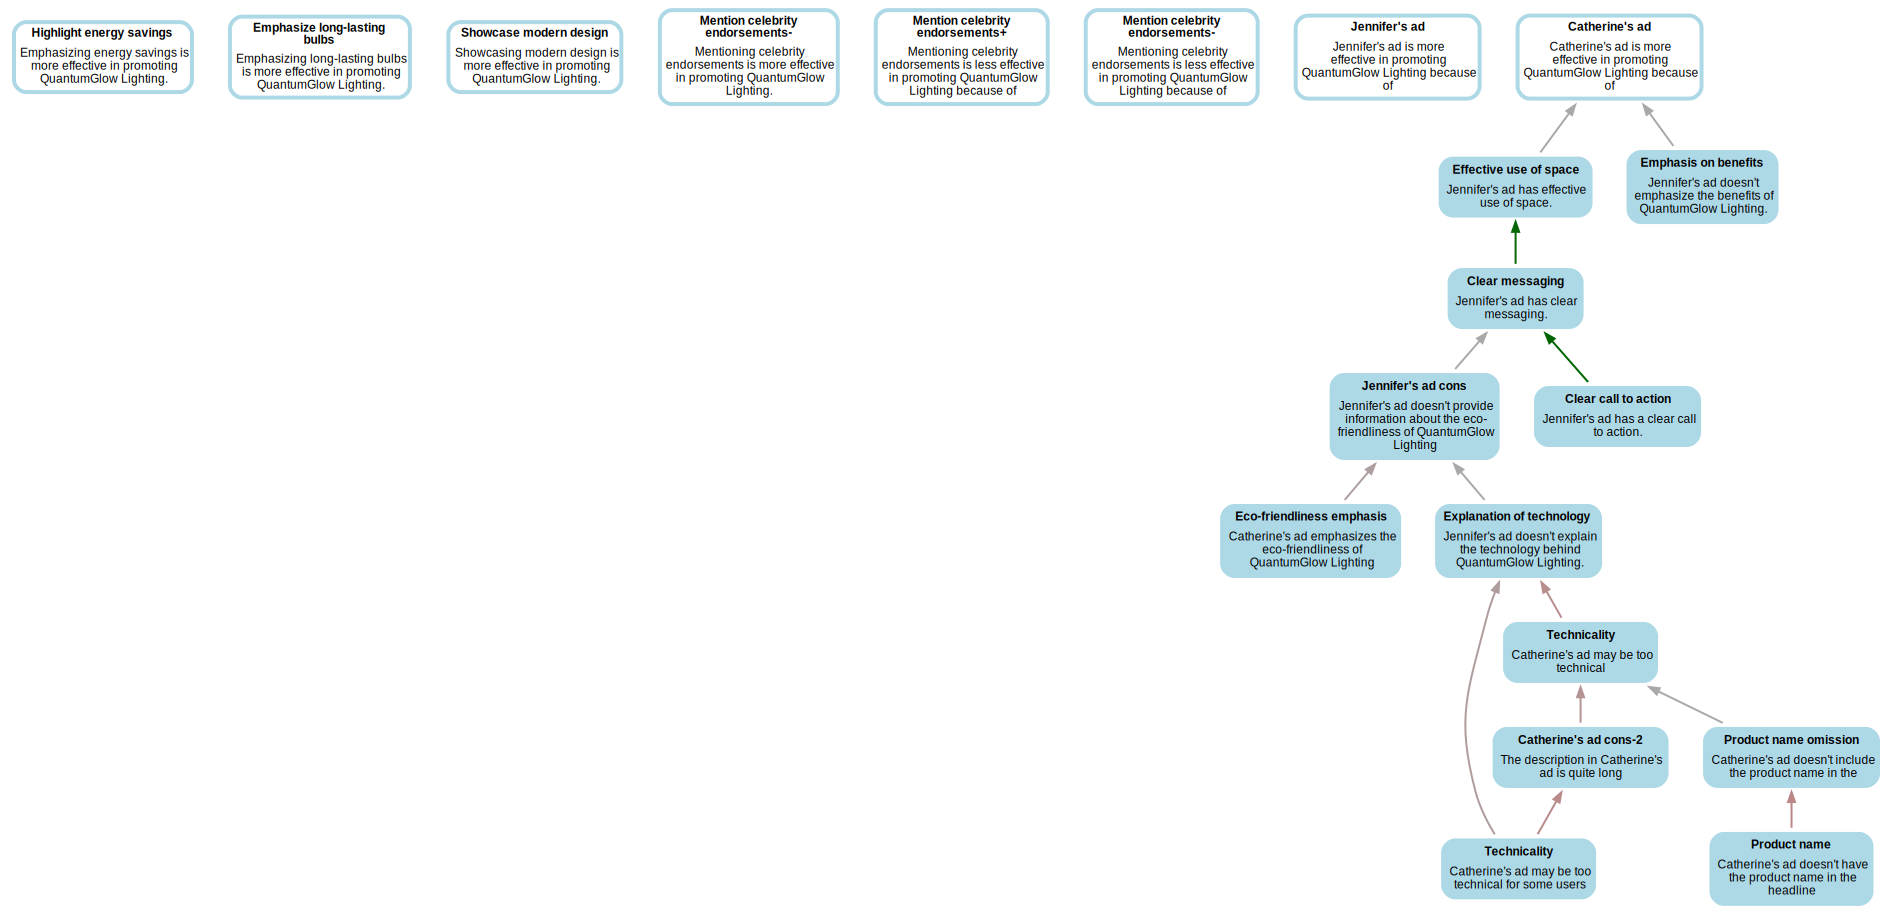

In [155]:
from IPython.display import display, Markdown

for artifact_id in config_dict.get("artifacts",[]):
  display(Markdown(f"## {artifact_id}"))
  data = df_scores.iloc[0].get(artifact_id)
  r = render_artifact(artifact_id, data)
  if isinstance(r, tuple):
    display(*r)
  else:
    display(r)



****

(c) 2023 The Logikon AI Team | License: Apache 2.0